# Peer-graded Assignment:
# Capstone Project - The Battle of Neighborhoods (Week 2)

## Segmenting and Clustering Neighborhoods in Toronto

In [1]:
# import libraries
import pandas as pd

# Web scraping and obtain the table of postal codes of Canada
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
table = pd.read_html(url)[0]

# Drop cells with a borough that is Not assigned
table.drop(table[table['Borough'] == 'Not assigned'].index, axis=0, inplace=True)

# Combine those neighborhoods that exist in the same post code area
table = table.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

# Fill those Not assigned neighborhood columns with its Borough
table.loc[table['Neighbourhood']=='Not assigned','Neighbourhood']= \
table[table['Neighbourhood']=='Not assigned']['Borough'].values

## Get the latitude and the longitude coordinates of each neighborhood

In [2]:
# Get the geographical coordinates from a csv file because I am not able to get them using the Geocoder package.
geo_table = pd.read_csv('http://cocl.us/Geospatial_data')

# merge table with geo_table to add latitude/longitude for each post code
merged_table = table.join(geo_table.set_index('Postal Code'), on='Postcode')

## Explore and cluster the neighborhoods in Toronto

In [3]:
# library to handle data in a vectorized manner
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!pip install folium
import folium

In [4]:
# Set display option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get the latitude and longitude coordinate of Toronto
address = 'Toronto'

geolocator = Nominatim(user_agent="shop_q") # explorer
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


## Create a map of Toronto with neighborhoods superimposed on top

In [5]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(merged_table['Latitude'], merged_table['Longitude'], \
                                            merged_table['Borough'], merged_table['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Slice the original dataframe.  Create a new dataframe of "Downtown Toronto" data.

In [6]:
# b_toronto is a dataframe of Central Toronto, Downtown Toronto, East Toronto and West Toronto data.
b_toronto = merged_table[merged_table['Borough'].str.contains("Downtown Toronto")].reset_index(drop=True)

# create map of the boroughs that contain the word "Toronto" using latitude and longitude values
map_b_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(b_toronto['Latitude'], b_toronto['Longitude'], \
                           b_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_b_toronto)  
    
map_b_toronto

## Define Foursquare Credentials and Version

In [7]:
# The code was removed by Watson Studio for sharing.

## Create a function to extracts the venues of neighborhoods

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Set limit of number of venues returned by Foursquare API
LIMIT = 200 # limit of number of venues returned by Foursquare API

## Extracts the venues of all the neighborhoods in Downtown Toronto

In [10]:
b_toronto_venues = getNearbyVenues(names=b_toronto['Neighbourhood'],
                                   latitudes=b_toronto['Latitude'],
                                   longitudes=b_toronto['Longitude']
                                  )

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park


## Segment the area in Downtown Toronto into 7 clusters by k-Means Clustering Algorithm

In [11]:
venues_loc = np.column_stack((b_toronto_venues['Venue Latitude'].values, b_toronto_venues['Venue Longitude'].values))

k_means5 = KMeans(init = "k-means++", n_clusters = 7, n_init = 12)
k_means5.fit(venues_loc)

b_toronto_venues['Cluster'] = k_means5.labels_

In [12]:
# create map of the venues using latitude and longitude values
map_venues = folium.Map(location=[latitude, longitude], zoom_start=13)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

# add markers to map
for lat, lng, label, cluster in zip(b_toronto_venues['Venue Latitude'], \
                                    b_toronto_venues['Venue Longitude'], \
                                    b_toronto_venues['Venue Category'], \
                                    b_toronto_venues['Cluster']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color=colors[cluster],
        parse_html=False).add_to(map_venues)  

    folium.CircleMarker(
        k_means5.cluster_centers_[cluster].tolist(),
        radius=5,
        popup=cluster,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)
map_venues

## Count number of restaurants, competitors and other venues in each cluster

In [13]:
restaurants=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("restaurant|diner", case=False)].groupby(['Cluster'])['Cluster'].count()
competitors=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("breakfast|coffee shop|café|bakery", case=False)].groupby(['Cluster'])['Cluster'].count()
other_venues=b_toronto_venues.groupby(['Cluster'])['Cluster'].count()-restaurants-competitors

## Plot a bar chart of number of venues in each cluster

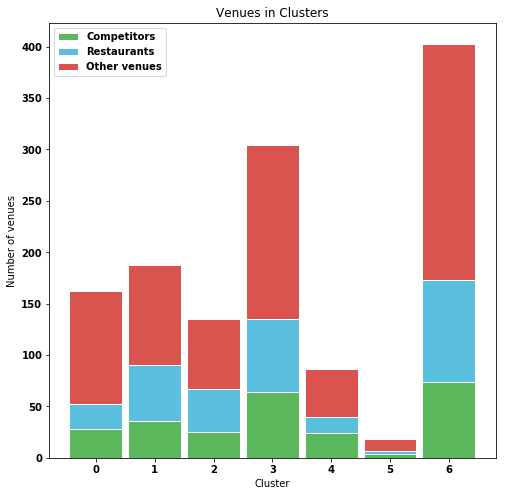

In [23]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = competitors.tolist()
bars2 = restaurants.tolist()
bars3 = other_venues.tolist()
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
positions = range(7)
names = range(7)
barWidth = 0.9
plt.figure(figsize=(8,8))
plt.title('Venues in Clusters')

# Create bars
plt.bar(positions, bars1, color='#5cb85c', edgecolor='white', width=barWidth, label='Competitors')
plt.bar(positions, bars2, bottom=bars1, color='#5bc0de', edgecolor='white', width=barWidth, label='Restaurants')
plt.bar(positions, bars3, bottom=bars, color='#d9534f', edgecolor='white', width=barWidth, label='Other venues')
 
plt.ylabel("Number of venues")
plt.xticks(positions, names, fontweight='bold')
plt.xlabel("Cluster")
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Plot a bar chart of 3 different types of venues in percentages

In [15]:
def annotate(width, percentage):
    i = 0
    for label in percentage:
        ax.annotate('{}'.format(label)+'%',
                    xy=(i+width/3, label),
                    ha='center',
                    va='bottom',
                    fontsize=12)
        i+=1

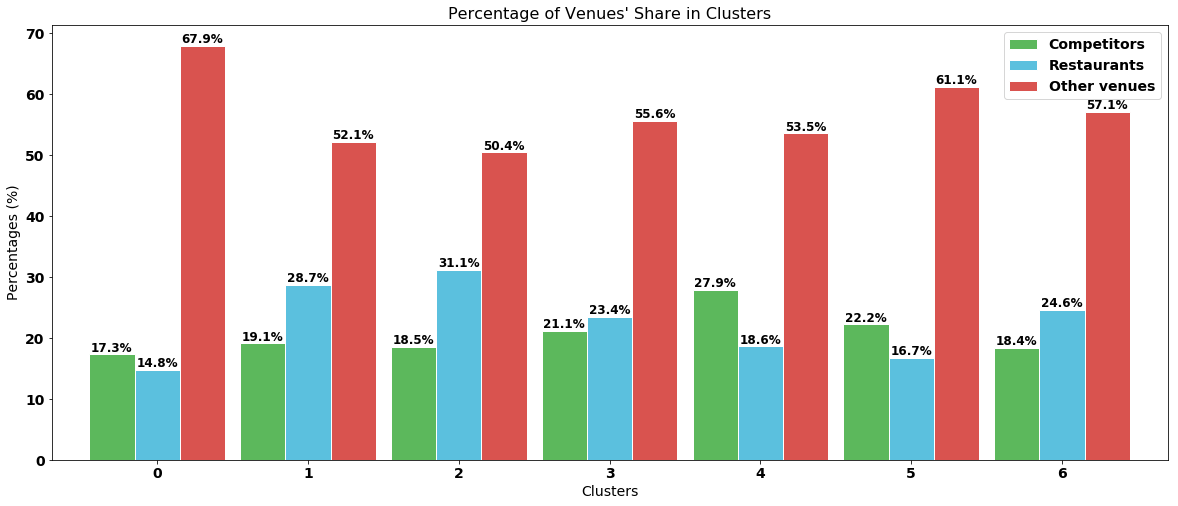

In [16]:
raw_data = {'Bars_p1': bars1, 'Bars_p2': bars2,'Bars_p3': bars3}
df = pd.DataFrame(raw_data)

totals = [i+j+k for i,j,k in zip(df['Bars_p1'], df['Bars_p2'], df['Bars_p3'])]
df_bars=df/[totals,totals,totals]*100
df_bars=df_bars.round(decimals=1)

df_bars.rename({'Bars_p1': 'Competitors', 'Bars_p2': 'Restaurants', 'Bars_p3': 'Other venues'}, axis=1, inplace=True)

# plot
ax = df_bars.plot(kind='bar', figsize=(20, 8), width=barWidth, \
                  color=['#5cb85c','#5bc0de','#d9534f'], \
                  edgecolor='white')

# Set font size 14 for the bar labels and legend
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=0)
ax.legend(fontsize=14)

# Set font size 16 for the title
ax.set_title('Percentage of Venues\' Share in Clusters', fontsize=16)

ax.set_xlabel('Clusters', fontsize=14)
ax.set_ylabel('Percentages (%)', fontsize=14)

annotate(-barWidth, df_bars['Competitors'])
annotate(0, df_bars['Restaurants'])
annotate(+barWidth, df_bars['Other venues'])

# Show graphic
plt.show()

## Count number of train stations and ferry terminals in each cluster

In [17]:
train=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("metro|light rail|train", case=False)].groupby(['Cluster'])['Cluster'].count()
ferry=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("ferry", case=False)].groupby(['Cluster'])['Cluster'].count()

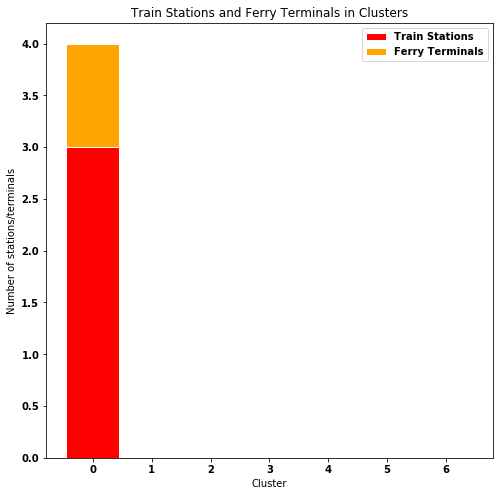

In [18]:
# Values of each group
bars1 = (pd.Series(np.zeros(7, dtype = int))+train).fillna(0).astype(int).tolist()
bars2 = (pd.Series(np.zeros(7, dtype = int))+ferry).fillna(0).astype(int).tolist()
 
positions = range(7)
names = range(7)
barWidth = 0.9
bar_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
plt.figure(figsize=(8,8))
plt.title('Train Stations and Ferry Terminals in Clusters')

# Create bars
plt.bar(positions, bars1, color=bar_colors[0], edgecolor='white', width=barWidth, label='Train Stations')
plt.bar(positions, bars2, bottom=bars1, color=bar_colors[1], edgecolor='white', width=barWidth, label='Ferry Terminals')
 
plt.ylabel("Number of stations/terminals")
plt.xticks(positions, names, fontweight='bold')
plt.xlabel("Cluster")
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Count number of theaters, concert halls, stadiums, shopping malls, museums and aquariums

In [19]:
theater=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("Theater", case=False)].groupby(['Cluster'])['Cluster'].count()
concert=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("Concert Hall", case=False)].groupby(['Cluster'])['Cluster'].count()
stadium=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("Stadium", case=False)].groupby(['Cluster'])['Cluster'].count()
mall=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("Shopping Mall", case=False)].groupby(['Cluster'])['Cluster'].count()
museum=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("Museum", case=False)].groupby(['Cluster'])['Cluster'].count()
aquarium=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("Aquarium", case=False)].groupby(['Cluster'])['Cluster'].count()

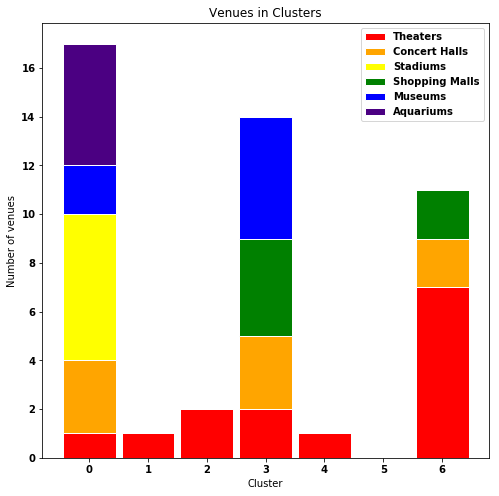

In [20]:
# Values of each group
bars1 = (pd.Series(np.zeros(7, dtype = int))+theater).fillna(0).astype(int).tolist()
bars2 = (pd.Series(np.zeros(7, dtype = int))+concert).fillna(0).astype(int).tolist()
bars3 = (pd.Series(np.zeros(7, dtype = int))+stadium).fillna(0).astype(int).tolist()
bars4 = (pd.Series(np.zeros(7, dtype = int))+mall).fillna(0).astype(int).tolist()
bars5 = (pd.Series(np.zeros(7, dtype = int))+museum).fillna(0).astype(int).tolist()
bars6 = (pd.Series(np.zeros(7, dtype = int))+aquarium).fillna(0).astype(int).tolist()

# Heights
h_2bars = np.add(bars1, bars2).tolist()
h_3bars = np.add(h_2bars, bars3).tolist()
h_4bars = np.add(h_3bars, bars4).tolist()
h_5bars = np.add(h_4bars, bars5).tolist()

positions = range(7)
names = range(7)
barWidth = 0.9

bar_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
plt.figure(figsize=(8,8))
plt.title('Venues in Clusters')

# Create bars
plt.bar(positions, bars1, color=bar_colors[0], edgecolor='white', width=barWidth, label='Theaters')
plt.bar(positions, bars2, bottom=bars1, color=bar_colors[1], edgecolor='white', width=barWidth, label='Concert Halls')
plt.bar(positions, bars3, bottom=h_2bars, color=bar_colors[2], edgecolor='white', width=barWidth, label='Stadiums')
plt.bar(positions, bars4, bottom=h_3bars, color=bar_colors[3], edgecolor='white', width=barWidth, label='Shopping Malls')
plt.bar(positions, bars5, bottom=h_4bars, color=bar_colors[4], edgecolor='white', width=barWidth, label='Museums')
plt.bar(positions, bars6, bottom=h_5bars, color=bar_colors[5], edgecolor='white', width=barWidth, label='Aquariums')

plt.ylabel("Number of venues")
plt.xticks(positions, names, fontweight='bold')
plt.xlabel("Cluster")
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Analyse the above data and plots

By analysing the above data and plots, the cluster has the most number of venues is cluster 6. The more the number of venues, the higher the chance of people movement in the cluster. The top 3 of the highest number of venues are in cluster 2, cluster 4 and cluster 6. However, the percentages of catering venues in these clusters are higher than 40% of the total number of venues. The catering venues include the venue categroies such as restaurant, diner, breakfast, coffee shop, café and bakery. Any new catering business in these clusters will face a big challenge of market share. Those percentages in cluster 0 and cluster 5 have 31.2% and 36.8% respectively.

A traffic interchange like tain station can increase the movement of people in the area. The data shows that there are 3 train stations in the cluster 0.

## Conclusion

By the analysis, the cluster has the lowest percentage of catering venues in the area. Besides, 3 train stations in the cluster 0 is beneficial to raise people traffic. Thus, a new coffee shop will be suggested to open in the cluster 0.

## Print the geographical coordinates of the cluster's center

In [21]:
cluster=b_toronto_venues[b_toronto_venues['Venue Category'].str.contains("metro|light rail|train", case=False)].groupby(['Cluster'])['Cluster'].count().index[0]
print("Latitude : %f, Longitude : %f" %(k_means5.cluster_centers_[cluster].tolist()[0],k_means5.cluster_centers_[cluster].tolist()[1]))

Latitude : 43.641395, Longitude : -79.383690


## Draw a circle area with a radius of 700 meters about the cluster's center on map

In [22]:
# create map of the boroughs that contain the word "Toronto" using latitude and longitude values
map_area = folium.Map(location=k_means5.cluster_centers_[cluster].tolist(), zoom_start=14)
    
folium.Circle(
    k_means5.cluster_centers_[cluster].tolist(),
    radius=700,
    popup="Cluster#"+str(cluster),
    color='black',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,
    parse_html=False).add_to(map_area)
map_area